# Plot model run times

## This script plots time-series modelled WL data and creates data visualisations for the neap and spring model periods

### Import Libraries

In [2]:
import tfv.xarray
import xarray as xr
import math
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import scipy.io
from scipy.signal import find_peaks
import numpy as np
from matplotlib.dates import DateFormatter
from scipy.io import loadmat
import matplotlib.dates as mdates
# define function to convert MATLAB datenum to pandas datetime
def convtime(matlab_datenum):
    return pd.to_datetime(matlab_datenum - 719529, unit='D')


### Open files as xarray objects

In [6]:
ds1 = xr.open_dataset(r"X:\Scratch1\aqua_highres_009.nc", decode_times=False)

Check what's inside

In [7]:
#ds1


Add TUFLOW FV Specific flavours to netcdfs by running `.tfv`

In [8]:
ds1.tfv


<xarray.Dataset>
Dimensions:      (Time: 15409, NumLayerFaces3D: 594840, NumCells2D: 34306,
                  NumCells3D: 560534)
Coordinates:
  * Time         (Time) datetime64[ns] 2022-05-01 ... 2022-12-01
Dimensions without coordinates: NumLayerFaces3D, NumCells2D, NumCells3D
Data variables:
    ResTime      (Time) float64 2.834e+05 2.834e+05 ... 2.885e+05 2.885e+05
    layerface_Z  (Time, NumLayerFaces3D) float32 ...
    stat         (Time, NumCells2D) int32 ...
    H            (Time, NumCells2D) float32 ...
    V_x          (Time, NumCells3D) float32 ...
    V_y          (Time, NumCells3D) float32 ...
    D            (Time, NumCells2D) float32 ...
    ZB           (Time, NumCells2D) float32 ...
    SAL          (Time, NumCells3D) float32 ...
    TEMP         (Time, NumCells3D) float32 ...
Attributes:
    Origin:     Created by TUFLOWFV
    Type:       Cell-centred TUFLOWFV output
    spherical:  true
    Dry depth:  0.01

## Get modelled WL timeseries data and plot

Organise sites of interest.   
Read these sites as a csv file.    
Specify the time range with start and end times.  
Get timeseries data

In [9]:
# read location data from csv file
loc_data = r'M:\aqua_pensites_latlon.csv'
df = pd.read_csv(loc_data, delimiter=',', usecols=['Lon', 'Lat', 'Site'])
locs = {}
for i, row in df.iterrows():
    locs[row['Site']] = (row['Lon'], row['Lat'])


In [10]:
# get time-series data for different variables
ts1 = ds1.tfv.get_timeseries(['H'], locs)
#ts2 = ds2.tfv.get_timeseries(['H'], locs)
# ts2_top = ds2.tfv.get_timeseries(['TEMP'], locs, datum='depth', limits=(0, 1))
# ts2_btm = ds2.tfv.get_timeseries(['TEMP'], locs, datum='height', limits=(0, 1))

Extracting timeseries, please wait: 100%|████████████████████████████████████████| 15409/15409 [13:46<00:00, 18.65it/s]


In [11]:
ts1

<xarray.Dataset>
Dimensions:   (Time: 15409, Location: 17)
Coordinates:
  * Time      (Time) datetime64[ns] 2022-05-01 ... 2022-12-01
  * Location  (Location) <U6 '1' '2' '3' '4' '5' ... '14' '15' '16' 'centre'
    x         (Location) float64 -5.082 -5.082 -5.083 ... -5.085 -5.085 -5.084
    y         (Location) float64 58.26 58.26 58.26 58.26 ... 58.26 58.26 58.26
    z         (Location) float32 -45.8 -47.17 -47.54 ... -44.37 -43.87 -49.88
Data variables:
    H         (Time, Location) float64 -1.053 -1.053 -1.053 ... -0.2075 -0.2082
Attributes:
    Origin:     Timeseries extracted from TUFLOWFV cell-centered output using...
    Type:       Timeseries cell from TUFLOWFV Output
    spherical:  true
    Dry depth:  0.01
    Datum:      sigma
    Limits:     (0, 1)
    Agg Fn:     mean

Feel free to chcek BMT colours and hex codes
https://www.bmtintra.net/corporateidentity/default.aspx?#palette-modal.  
  
hex_codes = [
    "#005581",
    "#1ABDC9",
    "#D6E9E0",
    "#E20177",
    "#D4D00F",
    "#00B6DD",
    "#7ED1E1",
    "#B9E0F7",
    "#D8D0C7",
    "#8B9B93",
    "#887665",
    "#4F5650"
]

### Neap Simulation period

Plot WL data at pen centre with the smallest spring maxima.

In [12]:
# set time range
start_time = dt.datetime(2022, 8, 10, 0, 0, 0)  # replace with your start time
end_time = dt.datetime(2022, 11, 10, 0, 0, 0)  # replace with your end time
#print(df)

Time of Smallest Spring Maxima: 2022-10-19T04:00:00.000000000


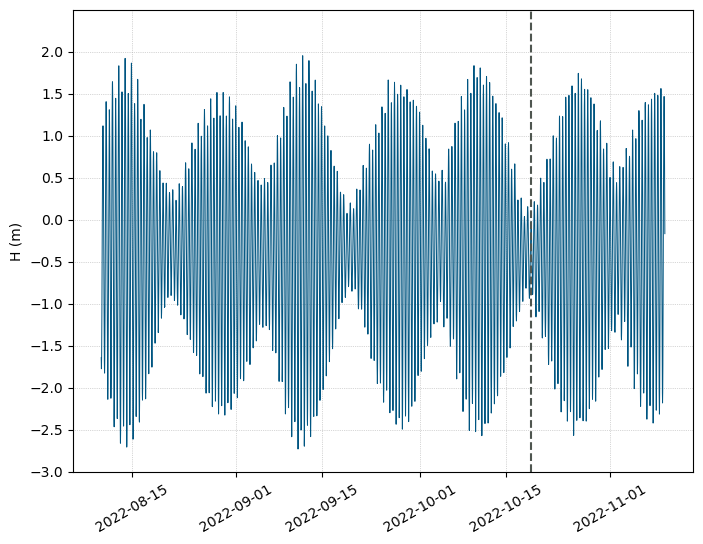

In [13]:
# Create the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

site = 'centre'

ts1_data = ts1.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='H')

# Extract datetime values and 'H' values
datetime_values = ts1_data.Time.values
h_values = ts1_data.values[0]

# Plot the data
axs.plot_date(datetime_values, h_values, fmt='-', color='#005581', label='MSL', linewidth=0.7)

# Find peaks (tide maxima)
peaks, _ = find_peaks(h_values, prominence=0.1, distance=30)  # Adjust the parameters based on your dataset

# Find the smallest peak (smallest spring maxima)
smallest_spring_peak_index = peaks[h_values[peaks].argmin()]
smallest_spring_peak_time = datetime_values[smallest_spring_peak_index]

# Add vertical lines at the corresponding smallest and highest spring maxima times
axs.vlines(x=smallest_spring_peak_time, ymin=-3, ymax=2.5, colors='#4F5650', linestyles='dashed', label='Last treatment')

# Set y-axis limits and ticks, and add y-axis label
axs.set_ylabel('H (m)')

axs.set_ylim(-3, 2.5)
axs.set_yticks(np.arange(-3, 2.5, 0.5))

# Set x-axis label to date format
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs.tick_params(axis='x', rotation=30)

# Add gridlines 
axs.yaxis.grid(True, which='major', linestyle=':', linewidth=0.5)
axs.xaxis.grid(True, which='major', linestyle=':', linewidth=0.5)

# Update the legend
# axs.legend(labels, loc='upper right', bbox_to_anchor=(1.28, 1), ncol=1, title='Neap')
# plt.setp(axs.get_legend().get_title(), weight='bold')

# Adjust subplot spacing
fig.subplots_adjust(hspace=0.5)

# Print the time of the smallest and highest spring maxima
print("Time of Smallest Spring Maxima:", smallest_spring_peak_time)

# Show the plot
plt.show()


Add a rectangle to indicate the simulation period.

Time of Smallest Spring Maxima: 2022-10-19T04:00:00.000000000


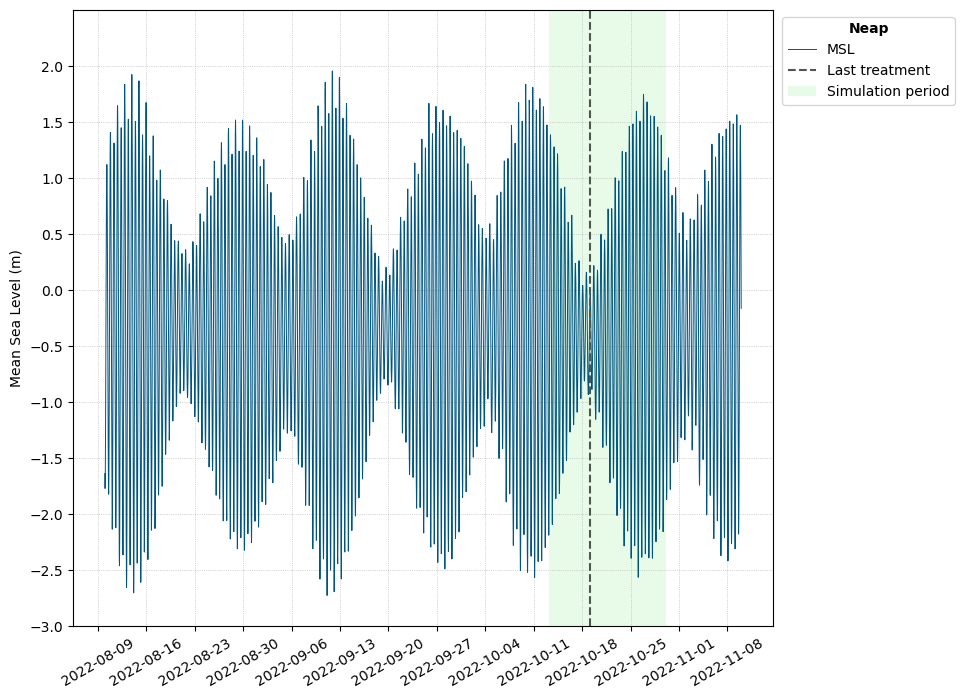

In [18]:
# Create the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
fig.subplots_adjust(left=0.1,right=0.8)

site = 'centre'

ts1_data = ts1.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='H')

# Extract datetime values and 'H' values
datetime_values = ts1_data.Time.values
h_values = ts1_data.values[0]

# Plot the data
axs.plot_date(datetime_values, h_values, fmt='-', color='#005581', label='MSL', linewidth=0.7)

# Find peaks (tide maxima)
peaks, _ = find_peaks(h_values, prominence=0.1, distance=30)  # Adjust the parameters based on your dataset

# Find the smallest peak (smallest spring maxima)
smallest_spring_peak_index = peaks[h_values[peaks].argmin()]
smallest_spring_peak_time = datetime_values[smallest_spring_peak_index]

# Add vertical lines at the corresponding smallest and highest spring maxima times
axs.vlines(x=smallest_spring_peak_time, ymin=-3, ymax=2.5, colors='#4F5650', linestyles='dashed', label='Last treatment')
#axs.vlines(x=highest_spring_peak_time, ymin=-3, ymax=2.5, colors='#4F5650', linestyles='dashed', label='Last treatment')

# Set y-axis limits and ticks, and add y-axis label
axs.set_ylabel('Mean Sea Level (m)')

# Set x-axis label to date format
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs.tick_params(axis='x', rotation=30)

# Set x-axis tick interval to every 7 days
axs.xaxis.set_major_locator(mdates.DayLocator(interval=7))

axs.set_ylim(-3, 2.5)
axs.set_yticks(np.arange(-3, 2.5, 0.5))

# Add gridlines 
axs.yaxis.grid(True, which='major', linestyle=':', linewidth=0.5)
axs.xaxis.grid(True, which='major', linestyle=':', linewidth=0.5)

# Add shaded rectangle for the plot
rect_start = smallest_spring_peak_time - pd.DateOffset(days=6)
rect_end = smallest_spring_peak_time + pd.DateOffset(days=11)
rect = axs.axvspan(rect_start, rect_end, facecolor='lightgreen', alpha=0.2)

# Get the existing legend handles and labels
handles, labels = axs.get_legend_handles_labels()

# Add the shaded rectangle to the legend
handles.append(rect)
labels.append('Simulation period')

# Update the legend
axs.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.27, 1), ncol=1, title='Neap')
plt.setp(axs.get_legend().get_title(), weight='bold')

# Adjust subplot spacing
fig.subplots_adjust(hspace=0.5)

# Print the time of the smallest and highest spring maxima
print("Time of Smallest Spring Maxima:", smallest_spring_peak_time)

# Save plot as PNG image with DPI of 300
fig.savefig('../figures/simulation_period_neap.png',dpi=300)

# Show the plot
plt.show()


### Spring Simulation Period

Plot WL data at pen centre with the highest spring maxima.

C:\Users\gayan.gunaratne\AppData\Local\Temp\ipykernel_31988\4055229689.py:45: UserWarning: Discarding nonzero nanoseconds in conversion.
  rect_start = highest_spring_peak_time - pd.DateOffset(days=6)
C:\Users\gayan.gunaratne\AppData\Local\Temp\ipykernel_31988\4055229689.py:46: UserWarning: Discarding nonzero nanoseconds in conversion.
  rect_end = highest_spring_peak_time + pd.DateOffset(days=11)


Time of Highest Spring Maxima: 2022-09-11T21:19:59.999998800


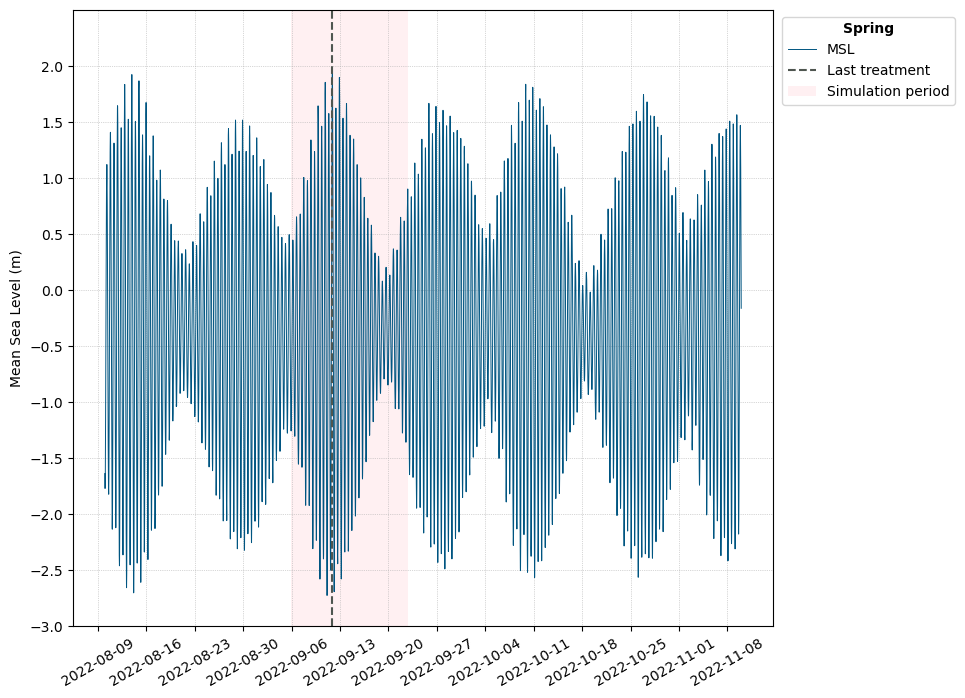

In [17]:
# Create the figure and axes
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
fig.subplots_adjust(left=0.1,right=0.8)

site = 'centre'

ts1_data = ts1.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='H')

# Extract datetime values and 'H' values
datetime_values = ts1_data.Time.values
h_values = ts1_data.values[0]

# Plot the data
axs.plot_date(datetime_values, h_values, fmt='-', color='#005581', label='MSL', linewidth=0.7)

# Find peaks (tide maxima)
peaks, _ = find_peaks(h_values, prominence=0.1, distance=30)  # Adjust the parameters based on your dataset

# Find the highest peak (highest spring maxima)
highest_spring_peak_index = peaks[h_values[peaks].argmax()]
highest_spring_peak_time = datetime_values[highest_spring_peak_index]

# Add vertical lines at the corresponding highest spring maxima times
axs.vlines(x=highest_spring_peak_time, ymin=-3, ymax=2.5, colors='#4F5650', linestyles='dashed', label='Last treatment')


# Set y-axis limits and ticks, and add y-axis label
axs.set_ylabel('Mean Sea Level (m)')

# Set x-axis label to date format
axs.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
axs.tick_params(axis='x', rotation=30)

# Set x-axis tick interval to every 7 days
axs.xaxis.set_major_locator(mdates.DayLocator(interval=7))

axs.set_ylim(-3, 2.5)
axs.set_yticks(np.arange(-3, 2.5, 0.5))

# Add gridlines 
axs.yaxis.grid(True, which='major', linestyle=':', linewidth=0.5)
axs.xaxis.grid(True, which='major', linestyle=':', linewidth=0.5)

# Add shaded rectangle for the plot
rect_start = highest_spring_peak_time - pd.DateOffset(days=6)
rect_end = highest_spring_peak_time + pd.DateOffset(days=11)
rect = axs.axvspan(rect_start, rect_end, facecolor='lightpink', alpha=0.2)

# Get the existing legend handles and labels
handles, labels = axs.get_legend_handles_labels()

# Add the shaded rectangle to the legend
handles.append(rect)
labels.append('Simulation period')

# Update the legend
axs.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.27, 1), ncol=1, title='Spring')
plt.setp(axs.get_legend().get_title(), weight='bold')

# Adjust subplot spacing
fig.subplots_adjust(hspace=0.5)

# Print the time of the smallest and highest spring maxima
print("Time of Highest Spring Maxima:", highest_spring_peak_time)

# Save plot as PNG image with DPI of 300
fig.savefig('../figures/simulation_period_spring.png',dpi=300)

# Show the plot
plt.show()


Extract WL time series data as a datframe

In [22]:
# Create an empty dataframe
data_df = pd.DataFrame()

site = 'centre'

ts1_data = ts1.sel(Location=site).sel(Time=slice(start_time, end_time)).to_array(name='H')

# Extract datetime values and 'H' values
datetime_values = ts1_data.Time.values
h_values = ts1_data.values[0]

# Assign values to dataframe columns
data_df['datetime'] = datetime_values
data_df['H'] = h_values

# Set 'datetime' column as the index
data_df.set_index('datetime', inplace=True)

# Find peaks (neap tide maxima)
peaks, _ = find_peaks(-h_values, prominence=0.1, distance=30)  # Adjust the parameters based on your dataset

# Find the smallest peak (neap tide maxima)
smallest_peak_index = peaks[h_values[peaks].argmin()]
smallest_peak_time = datetime_values[smallest_peak_index]

# Format datetime values in the desired format
data_df.index = data_df.index.strftime('%Y/%m/%d %H:%M:%S')

# Print the formatted dataframe
print(data_df)

# Save the DataFrame to a CSV file
data_df.to_csv('../data/WL_timeseries_dataV3.csv', index=True)

#data_df['datetime'] = pd.to_datetime(data_df['datetime'])
# Save the DataFrame to a CSV file
#data_df.to_csv('../data/WL_timeseries_dataV2.csv', index=False)

# Print the time of the smallest peak (neap tide maxima)
print("Time of Smallest Neap Tide Maxima:", smallest_peak_time)


                            H
datetime                     
2022/08/10 00:00:00 -1.640926
2022/08/10 00:19:59 -1.731850
2022/08/10 00:40:00 -1.773991
2022/08/10 01:00:00 -1.765442
2022/08/10 01:19:59 -1.712379
...                       ...
2022/11/09 22:40:00  0.884693
2022/11/09 23:00:00  0.670948
2022/11/09 23:19:59  0.412979
2022/11/09 23:40:00  0.119125
2022/11/10 00:00:00 -0.165447

[6625 rows x 1 columns]
